# Logistic model

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import statsmodels.api as sm


MODEL: FULL MODEL - All Features
Features: 28
AUC: 0.667
Gini: 0.333
Pseudo R²: 0.063
Features: 28
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               275840
Model:                          Logit   Df Residuals:                   275811
Method:                           MLE   Df Model:                           28
Date:                Mon, 03 Nov 2025   Pseudo R-squ.:                 0.06329
Time:                        03:26:39   Log-Likelihood:            -1.7484e+05
converged:                       True   LL-Null:                   -1.8665e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                0.4187      0.004    101.353 

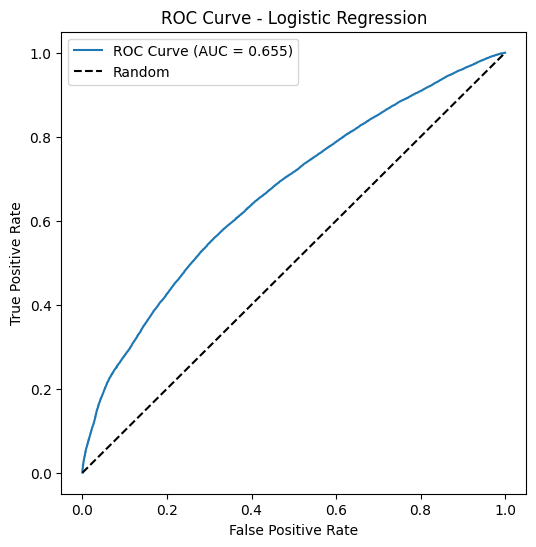

In [124]:
df = pd.read_parquet('data_processed.parquet')

def fit_logistic_model(features, model_name):
    """Fit logistic regression and return results"""
    
    print(f"\n{'='*60}")
    print(f"MODEL: {model_name}")
    print(f"{'='*60}")
    print(f"Features: {len(features)}")
    
    # Prepare data
    X = df[features]
    y = df['target']
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features, index=X_test.index)
    
    # Fit model
    X_train_sm = sm.add_constant(X_train_scaled)
    X_test_sm = sm.add_constant(X_test_scaled)
    
    model = sm.Logit(y_train, X_train_sm)
    result = model.fit(disp=0)
    
    # Predictions and metrics
    y_pred_proba = result.predict(X_test_sm)
    auc = roc_auc_score(y_test, y_pred_proba)
    gini = 2 * auc - 1
    
    print(f"AUC: {auc:.3f}")
    print(f"Gini: {gini:.3f}")
    print(f"Pseudo R²: {result.prsquared:.3f}")
    print(f"Features: {len(features)}")
    
    return result, auc, gini

# Get all numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns
all_features = [col for col in numeric_cols if col != 'target']

# Fit model
full_result, full_auc, full_gini = fit_logistic_model(all_features, "FULL MODEL - All Features")
print(full_result.summary())

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = 0.655)')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve - Logistic Regression')
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')